In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import sys, os; sys.path.insert(0, '../')
import BaryonForge as bfg
import pyccl as ccl
from astropy.io import fits

#Load cosmology object from CCL. Linear P(k) is needed since we use it for 2-halo term.
#We don't use P(k) anywhere else in this model, so it's ok to use linear P(k) throughout
cosmo = ccl.Cosmology(Omega_c = 0.3175 - 0.049 , Omega_b = 0.049, h=0.6711, sigma8=0.82, n_s=0.96,
                      matter_power_spectrum='linear')
h = cosmo.cosmo.params.h

#Config params. Let's use the default values as deemed in Schneider19
bpar = dict(theta_ej = 4, theta_co = 0.1, 
            M_c = 1e14/h,
            mu_beta = 0.7, #We set this to 1 and then change M_c to get the right \beta value
            eta = 0.3, eta_delta = 0.3, 
            tau = 0, tau_delta = 0, #They don't use a tau so we zero ours
            A = 0.09/2, #Factor 2 Needed so that the high-mass behaviors of our model is same as theirs
            M1 = 2.5e11/h,
            epsilon_h = 0.015, eta_cga = 0.6, a = 0.3, n = 2, epsilon = 4, p = 0.3, q = 0.707, 
            gamma = 2, delta = 7)

In [2]:
#Some plotting configs
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=22)
plt.rcParams["axes.linewidth"]  = 2.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]

## Download files

These are files from the [ULAGAM simulations](https://ulagam-simulations.readthedocs.io/) hosted on gdrive specifically for this example notebook

In [3]:
!rm shell.fits.fz halos.npy

!wget -O shell.fits.fz "https://drive.google.com/uc?export=download&id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6"
!wget -O halos.npy     "https://drive.google.com/uc?export=download&id=1JhtFwOzfHG5YWXUDYP1HFfAkq6v5YHKm"

--2025-04-16 09:01:01--  https://drive.google.com/uc?export=download&id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6
Resolving drive.google.com (drive.google.com)... 142.251.32.14, 2607:f8b0:4009:814::200e
Connecting to drive.google.com (drive.google.com)|142.251.32.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6&export=download [following]
--2025-04-16 09:01:02--  https://drive.usercontent.google.com/download?id=1JjH5EnW4TlNF8n823K9-DnbkqczL5dj6&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.190.33, 2607:f8b0:4009:809::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.190.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5705280 (5.4M) [application/octet-stream]
Saving to: ‘shell.fits.fz’

shell.fits.fz       100%[===================>]   5.44M  5.32MB/s    in 1.0s 

## Load shell and catalog

In [4]:
min_z = 0.2129219
max_z = 0.2395602

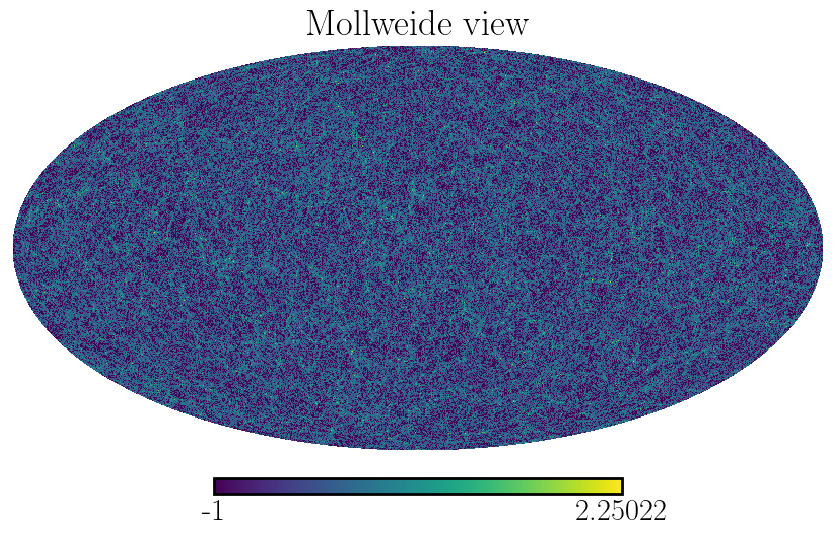

In [5]:
counts  = fits.open('shell.fits.fz')[1].data
density = counts/np.mean(counts) - 1

hp.mollview(np.log10(1.1 + density))

In [6]:
halos = np.load('halos.npy')

In [7]:
shell_thickness = ccl.comoving_radial_distance(cosmo, 1/(max_z + 1)) - ccl.comoving_radial_distance(cosmo, 1/(min_z + 1))
bpar['proj_cutoff'] = shell_thickness/2

print(f"SHELL IS {shell_thickness} MPC")

SHELL IS 105.67531144558131 MPC


In [8]:
#This is set in units of halo R200c radius.
#You want this to be larger than the radius where you displacement
#function asymptotes to 0
bpar['epsilon_max'] = 10

## Now setup the models

In [9]:
#Generate a series of 5 models, varying a parameter (M_c)

tej_vals = [2, 3, 4, 6, 8]
Model    = []
for tej in tej_vals:
    
    bpar['theta_ej'] = tej
    
    #DMO and DMB models
    DMO = bfg.Profiles.DarkMatterOnly(**bpar)
    DMB = bfg.Profiles.DarkMatterBaryon(**bpar)
    
    PIX = bfg.HealPixel(1024)
    DMO = bfg.ConvolvedProfile(DMO, PIX)
    DMB = bfg.ConvolvedProfile(DMB, PIX)

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfg.Profiles.Baryonification2D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
    Displacement.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True, 
                                    M_min = 1e12, M_max = 1e16)
    
    Model.append(Displacement)

Building Table:   0%|                                                                             | 0/2 [00:00<?, ?it/s]/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:284: UserWarning: WARNING: Profile is zero/negative in some places.Likely a convolution artifact for objects smaller than the pixel scale
  warnings.warn("WARNING: Profile is zero/negative in some places."
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:1006: UserWarning: Decrease integral lower limit, r_min_int (1e-08) < minimum radius (8.333333333333334e-10)
  warnings.warn(f"Decrease integral lower limit, r_min_int ({self.r_min_int}) < minimum radius ({np.min(r)})", UserWarning)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:1008: UserWarning: Increase integral upper limit, r_max_int (100000.0) < maximum radius (1200000.0)
  warnings.warn(f"Increase integral up

## Now setup the runners

In [10]:
#Each model gets its own runner

#A dictionary of cosmology params to pass to runner
cdict   = {'Omega_m' : 0.3175, 'sigma8' : 0.834, 'h' : 0.6711, 'n_s' : 0.9649, 'w0' : -1, 'Omega_b' : 0.049}

#Put halos and the field into I/O objects.
#The shell should be a MASS shell, not a density shell.
halos   = bfg.utils.HaloLightConeCatalog(halos['ra'], halos['dec'], halos['M'], halos['z'], cosmo = cdict)
shell   = bfg.utils.LightconeShell(map = counts, cosmo = cdict)
Runners = []

for M in Model:
    
    Runners.append(
        bfg.Runners.BaryonifyShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = M, verbose = True)
    )

## Now run it!

In [11]:
# Or even better, you can run it in parallel! :)
# I set njobs to 1 just to have this run on my (aging :P) laptop

Parallel_Runner    = bfg.utils.SimpleParallel(Runners, njobs = 1)
baryonified_shells = Parallel_Runner.process()

Baryonifying matter: 100%|███████████████████████████████████████████████████████| 18512/18512 [00:32<00:00, 571.98it/s]
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   52.6s
Baryonifying matter: 100%|███████████████████████████████████████████████████████| 18512/18512 [00:33<00:00, 546.20it/s]
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  3.5min
Baryonifying matter: 100%|███████████████████████████████████████████████████████| 18512/18512 [00:35<00:00, 522.22it/s]


## Finally, let's plot the ratios of Cls

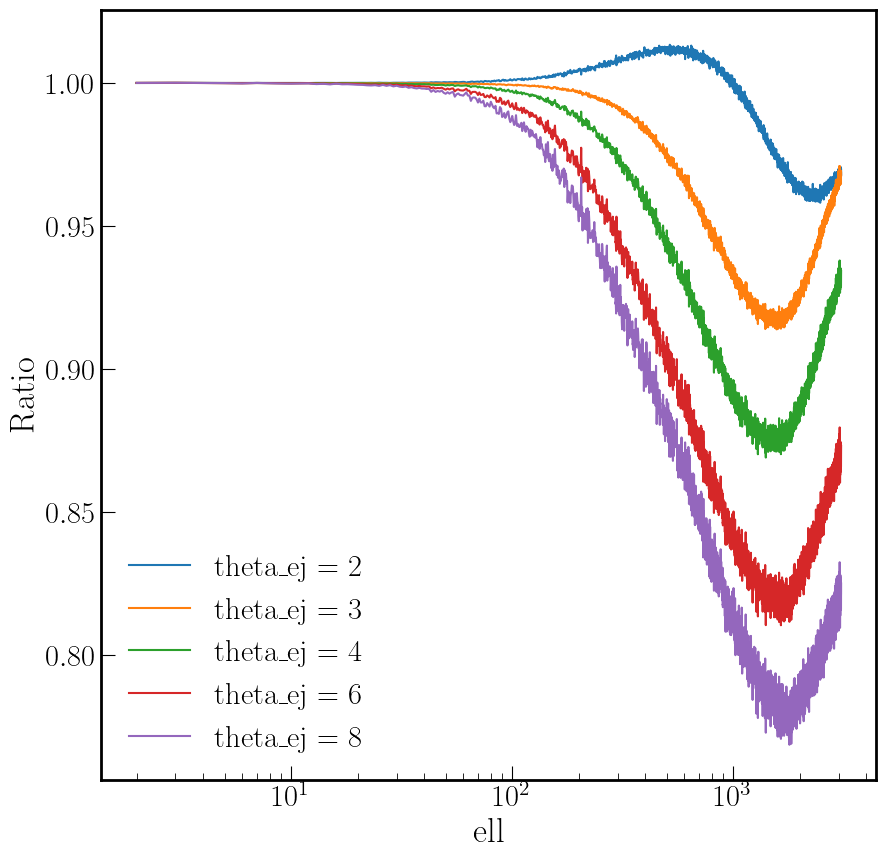

In [12]:
#Compute Cls of the original map
baseline = hp.anafast(counts)
ell      = np.arange(baseline.size)

for s, M in zip(baryonified_shells, tej_vals):
    
    #Compute Cls of the modified map
    modified = hp.anafast(s)
    
    #Plot ratios. Dont show monopole and dipole modes
    plt.plot(ell[2:], (modified/baseline)[2:], label = f'theta_ej = {M}')
    

plt.legend(frameon = False)
plt.xlabel('ell', size = 25)
plt.ylabel('Ratio', size = 25)
plt.xscale('log')

# Similar procedure but for $\eta_{\rm cga}$

In [13]:
#Generate a series of 5 models, varying a parameter (M_c)

etadelta_vals = [0.1, 0.2, 0.3, 0.4, 0.5]
Model         = []
bpar['theta_ej'] = 4
for ed in etadelta_vals:
    
    bpar['eta_delta'] = ed
    
    #DMO and DMB models
    DMO = bfg.Profiles.DarkMatterOnly(**bpar)
    DMB = bfg.Profiles.DarkMatterBaryon(**bpar)
    
    PIX = bfg.HealPixel(1024)
    DMO = bfg.ConvolvedProfile(DMO, PIX)
    DMB = bfg.ConvolvedProfile(DMB, PIX)

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfg.Profiles.Baryonification2D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
    Displacement.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True, 
                                    M_min = 1e12, M_max = 1e16)
    
    Model.append(Displacement)

Building Table:   0%|                                                                             | 0/2 [00:00<?, ?it/s]/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:284: UserWarning: WARNING: Profile is zero/negative in some places.Likely a convolution artifact for objects smaller than the pixel scale
  warnings.warn("WARNING: Profile is zero/negative in some places."
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:1006: UserWarning: Decrease integral lower limit, r_min_int (1e-08) < minimum radius (8.333333333333334e-10)
  warnings.warn(f"Decrease integral lower limit, r_min_int ({self.r_min_int}) < minimum radius ({np.min(r)})", UserWarning)
/mnt/g/My Drive/OneDrive/Research/GitHub/BaryonForge/examples/../BaryonForge/Profiles/Schneider19.py:1008: UserWarning: Increase integral upper limit, r_max_int (100000.0) < maximum radius (1200000.0)
  warnings.warn(f"Increase integral up

In [14]:
cdict   = {'Omega_m' : 0.3175, 'sigma8' : 0.834, 'h' : 0.6711, 'n_s' : 0.9649, 'w0' : -1, 'Omega_b' : 0.049}

Runners = []
for M in Model:
    
    Runners.append(
        bfg.Runners.BaryonifyShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = M, verbose = True)
    )

In [15]:
Parallel_Runner    = bfg.utils.SimpleParallel(Runners, njobs = 1)
baryonified_shells = Parallel_Runner.process()

Baryonifying matter: 100%|███████████████████████████████████████████████████████| 18512/18512 [00:34<00:00, 543.97it/s]
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   54.7s
Baryonifying matter: 100%|███████████████████████████████████████████████████████| 18512/18512 [00:35<00:00, 524.94it/s]
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  3.5min
Baryonifying matter: 100%|███████████████████████████████████████████████████████| 18512/18512 [00:32<00:00, 567.50it/s]


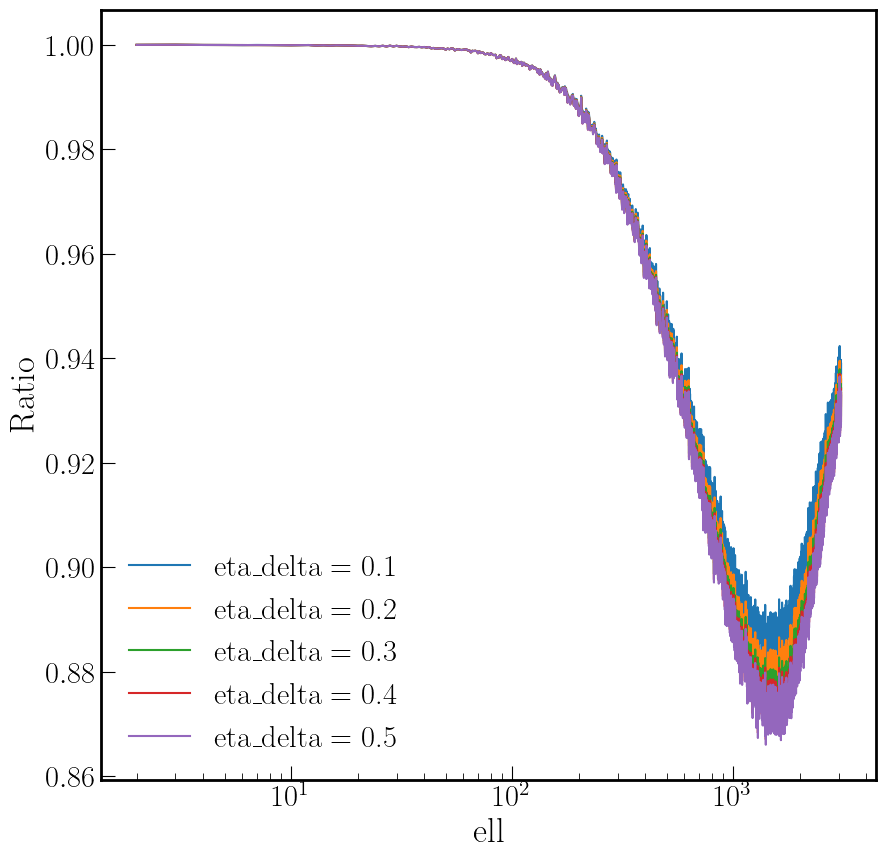

In [16]:
#Compute Cls of the original map
baseline = hp.anafast(counts)
ell      = np.arange(baseline.size)

for s, M in zip(baryonified_shells, etadelta_vals):
    
    #Compute Cls of the modified map
    modified = hp.anafast(s)
    
    #Plot ratios. Dont show monopole and dipole modes
    plt.plot(ell[2:], (modified/baseline)[2:], label = f'eta_delta = {M}')
    

plt.legend(frameon = False)
plt.xlabel('ell', size = 25)
plt.ylabel('Ratio', size = 25)
plt.xscale('log')

# Similar procedure but for $\mu$

In [17]:
#Generate a series of 5 models, varying a parameter (M_c)

mu_vals = [0.2, 0.3, 0.4, 0.5, 0.6]
Model         = []
bpar['theta_ej'] = 4
bpar['eta_delta'] = 0.3
for mu in mu_vals:
    
    bpar['mu_beta'] = mu
    
    #DMO and DMB models
    DMO = bfg.Profiles.DarkMatterOnly(**bpar)
    DMB = bfg.Profiles.DarkMatterBaryon(**bpar)
    
    PIX = bfg.HealPixel(1024)
    DMO = bfg.ConvolvedProfile(DMO, PIX)
    DMB = bfg.ConvolvedProfile(DMB, PIX)

    #Regular displacement model. We init it and also run the tabulator
    Displacement = bfg.Profiles.Baryonification2D(DMO, DMB, cosmo = cosmo, epsilon_max = bpar['epsilon_max'])
    Displacement.setup_interpolator(z_min = min_z, z_max = max_z, N_samples_z = 2, z_linear_sampling = True, 
                                    R_min = 1e-4, R_max = 300, N_samples_R = 2000, verbose = True, 
                                    M_min = 1e12, M_max = 1e16)
    
    Model.append(Displacement)

Building Table: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:16<00:00,  8.08s/it]


In [18]:
Runners = []
for M in Model:
    
    Runners.append(
        bfg.Runners.BaryonifyShell(halos, shell, epsilon_max = bpar['epsilon_max'], model = M, verbose = True)
    )

In [19]:
Parallel_Runner    = bfg.utils.SimpleParallel(Runners, njobs = 1)
baryonified_shells = Parallel_Runner.process()

Baryonifying matter: 100%|███████████████████████████████████████████████████████| 18512/18512 [00:33<00:00, 555.31it/s]
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  1.1min
Baryonifying matter: 100%|███████████████████████████████████████████████████████| 18512/18512 [00:31<00:00, 590.97it/s]
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  3.7min
Baryonifying matter: 100%|███████████████████████████████████████████████████████| 18512/18512 [00:33<00:00, 552.14it/s]


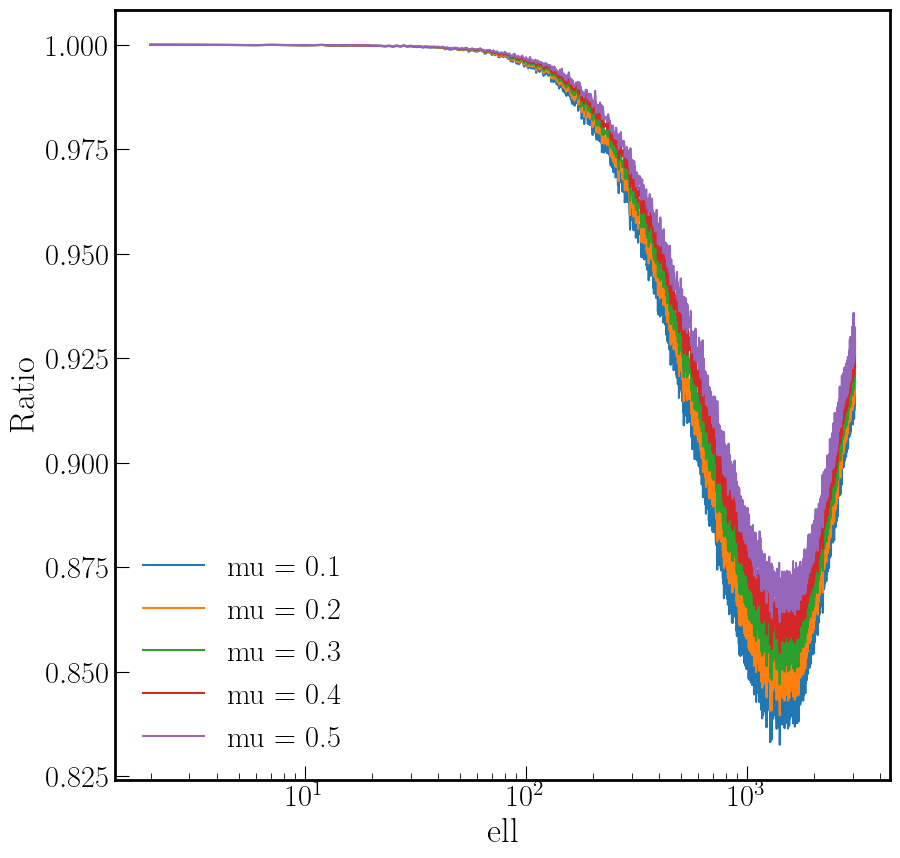

In [20]:
#Compute Cls of the original map
baseline = hp.anafast(counts)
ell      = np.arange(baseline.size)

for s, M in zip(baryonified_shells, etadelta_vals):
    
    #Compute Cls of the modified map
    modified = hp.anafast(s)
    
    #Plot ratios. Dont show monopole and dipole modes
    plt.plot(ell[2:], (modified/baseline)[2:], label = f'mu = {M}')
    

plt.legend(frameon = False)
plt.xlabel('ell', size = 25)
plt.ylabel('Ratio', size = 25)
plt.xscale('log')